In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re

from scipy.optimize import minimize
import scipy.stats as stat
from scipy.special import factorial, gamma
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import power_transform, normalize, MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.api import OLS, WLS
import seaborn as sns

import itertools

# Preparing Data

In [3]:
data = pd.read_csv(r"emotional_speech.csv")
data2 = pd.read_csv(r'Pres_data2.csv')
data['feature'] = data['feature'].apply(lambda x: re.sub(r'[\[\]\',]','', x)).str.split(' ')
data.head()

,path,feature
0,Users/vasantm/New folder/Audio/February_21_202...,"[disgust, happy, neutral, disgust, sad, sad, h..."
1,Users/vasantm/New folder/Audio/February_7_2023...,"[neutral, angry, neutral, neutral, neutral, ne..."
2,Users/vasantm/New folder/Audio/September_21_20...,"[sad, neutral, angry, angry, angry, happy, hap..."
3,Users/vasantm/New folder/Audio/September_1_202...,"[neutral, neutral, neutral, neutral, angry, di..."
4,Users/vasantm/New folder/Audio/May_24_2022_Rem...,"[happy, disgust, disgust, sad, disgust, happy,..."


In [4]:
classes = pd.Series([i for j in data['feature'] for i in j]).unique()
classes

array(['disgust', 'happy', 'neutral', 'sad', 'angry', 'fearful'],
      dtype=object)

In [5]:
def transition_matrix(x, emotion1, emotion2):
    count_1 = [i for i in x if i == emotion1]
    count_1_len = len(count_1)
    count_2_1 = 0
    for i in range(len(x)-1):
        if x[i] == emotion1 and x[i+1] == emotion2:
            count_2_1 += 1
    return count_2_1, count_1_len

In [6]:
transition_matrix(data['feature'][1], 'neutral', 'neutral')

(2930, 4343)

In [7]:
emotion_matrix = np.zeros(shape = (len(classes), len(classes)))

for i, row in enumerate(classes):
    for j, col in enumerate(classes):
        emotion_matrix[i,j] = transition_matrix(data['feature'][1],row,col)[0]/(transition_matrix(data['feature'][1],row,col)[1])

norm_matrix = emotion_matrix/emotion_matrix.sum(axis=1, keepdims=True)

pd.DataFrame(norm_matrix, columns=classes, index=classes)

,disgust,happy,neutral,sad,angry,fearful
disgust,0.236304,0.231023,0.147855,0.234323,0.108251,0.042244
happy,0.166023,0.241313,0.187741,0.239382,0.124517,0.041023
neutral,0.046051,0.084274,0.674649,0.133318,0.051117,0.010592
sad,0.164476,0.220432,0.212802,0.262823,0.116575,0.022891
angry,0.151543,0.228675,0.219601,0.227768,0.136116,0.036298
fearful,0.185304,0.268371,0.175719,0.185304,0.108626,0.076677


In [8]:
def trans_matrix(x_list, classes = classes):
    feature_matrix = []
    for t, features in enumerate(x_list):
        emotion_matrix = np.zeros(shape = (len(classes), len(classes)))

        for i, row in enumerate(classes):
            for j, col in enumerate(classes):
                if transition_matrix(features,row,col)[1] != 0 and transition_matrix(features,row,col)[0] != 0:
                    emotion_matrix[i,j] = transition_matrix(features,row,col)[0]/transition_matrix(features,row,col)[1]
                else:
                    emotion_matrix[i,j] = 1e-6
        norm_matrix = emotion_matrix/emotion_matrix.sum(axis=1, keepdims=True)
        feature_matrix.append(emotion_matrix.reshape(-1))
        print(t)
    return feature_matrix

trans_emote = trans_matrix(data['feature'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [9]:
title = []

for i in classes:
    for j in classes:
        title.append(f'{i}_to_{j}')

In [10]:
prob_emote = pd.DataFrame(trans_emote, columns=title)
prob_emote

,disgust_to_disgust,disgust_to_happy,disgust_to_neutral,disgust_to_sad,disgust_to_angry,disgust_to_fearful,happy_to_disgust,happy_to_happy,happy_to_neutral,happy_to_sad,...,angry_to_neutral,angry_to_sad,angry_to_angry,angry_to_fearful,fearful_to_disgust,fearful_to_happy,fearful_to_neutral,fearful_to_sad,fearful_to_angry,fearful_to_fearful
0,0.580607,0.179907,0.066589,0.110981,0.049065,0.012850,0.265378,0.309315,0.163445,0.191564,...,0.097015,0.223881,0.104478,0.007463,0.428571,0.178571,0.142857,0.214286,0.035714,0.000001
1,0.236304,0.231023,0.147855,0.234323,0.108251,0.042244,0.166023,0.241313,0.187741,0.239382,...,0.219402,0.227561,0.135993,0.036265,0.185304,0.268371,0.175719,0.185304,0.108626,0.076677
2,0.290224,0.240326,0.084521,0.183299,0.158859,0.042770,0.259887,0.227119,0.073446,0.207910,...,0.067055,0.209913,0.195335,0.049563,0.232394,0.225352,0.077465,0.281690,0.169014,0.014085
3,0.116822,0.182243,0.364486,0.126168,0.130841,0.079439,0.064234,0.255474,0.357664,0.147445,...,0.354922,0.129534,0.124352,0.038860,0.110092,0.192661,0.412844,0.082569,0.146789,0.055046
4,0.293651,0.218254,0.103175,0.214286,0.091270,0.079365,0.324176,0.181319,0.076923,0.236264,...,0.086420,0.259259,0.123457,0.037037,0.353846,0.184615,0.061538,0.200000,0.076923,0.123077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,0.190229,0.168399,0.166320,0.073805,0.270270,0.130977,0.230855,0.174251,0.185350,0.083241,...,0.166918,0.085347,0.272659,0.121601,0.170088,0.206745,0.158358,0.051320,0.259531,0.153959
274,0.119850,0.183521,0.273408,0.168539,0.209738,0.044944,0.081690,0.147887,0.408451,0.161972,...,0.320755,0.173854,0.266846,0.033693,0.089552,0.231343,0.246269,0.194030,0.186567,0.052239
275,0.167453,0.523585,0.122642,0.141509,0.023585,0.021226,0.060646,0.689770,0.110297,0.103965,...,0.129252,0.265306,0.068027,0.013605,0.137500,0.325000,0.212500,0.250000,0.025000,0.050000
276,0.122056,0.218415,0.319058,0.169165,0.128480,0.042827,0.098018,0.190529,0.352423,0.186123,...,0.344444,0.171429,0.150794,0.050794,0.097674,0.218605,0.320930,0.144186,0.153488,0.065116


In [14]:
data3 = pd.concat([data2['avg_approval_rate_change'], prob_emote], axis = 1)
data3.head()

,avg_approval_rate_change,disgust_to_disgust,disgust_to_happy,disgust_to_neutral,disgust_to_sad,disgust_to_angry,disgust_to_fearful,happy_to_disgust,happy_to_happy,happy_to_neutral,...,angry_to_neutral,angry_to_sad,angry_to_angry,angry_to_fearful,fearful_to_disgust,fearful_to_happy,fearful_to_neutral,fearful_to_sad,fearful_to_angry,fearful_to_fearful
0,-2.666667,0.580607,0.179907,0.066589,0.110981,0.049065,0.012850,0.265378,0.309315,0.163445,...,0.097015,0.223881,0.104478,0.007463,0.428571,0.178571,0.142857,0.214286,0.035714,0.000001
1,1.200000,0.236304,0.231023,0.147855,0.234323,0.108251,0.042244,0.166023,0.241313,0.187741,...,0.219402,0.227561,0.135993,0.036265,0.185304,0.268371,0.175719,0.185304,0.108626,0.076677
2,-0.400000,0.290224,0.240326,0.084521,0.183299,0.158859,0.042770,0.259887,0.227119,0.073446,...,0.067055,0.209913,0.195335,0.049563,0.232394,0.225352,0.077465,0.281690,0.169014,0.014085
3,0.500000,0.116822,0.182243,0.364486,0.126168,0.130841,0.079439,0.064234,0.255474,0.357664,...,0.354922,0.129534,0.124352,0.038860,0.110092,0.192661,0.412844,0.082569,0.146789,0.055046
4,-1.000000,0.293651,0.218254,0.103175,0.214286,0.091270,0.079365,0.324176,0.181319,0.076923,...,0.086420,0.259259,0.123457,0.037037,0.353846,0.184615,0.061538,0.200000,0.076923,0.123077


### Channel Regression

In [20]:
titles = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']

       
def multi(emotion1, list):
    emotion_list = [] 
    emotion_list.append(f'avg_approval_rate_change')
    for j in list:
        emotion_list.append(f'{j}_to_{emotion1}')
    return emotion_list


In [21]:
multi_col = [multi(i, titles) for i in titles]

In [22]:
emotion_data = {}

for i,j in enumerate(titles):
    emotion_data[f'{j}_channel'] = data3[multi_col[i]] 
    
names = emotion_data.keys()
names

dict_keys(['neutral_channel', 'happy_channel', 'sad_channel', 'angry_channel', 'fearful_channel', 'disgust_channel'])

## Example

In [26]:
happy_data = emotion_data['happy_channel']
y = happy_data['avg_approval_rate_change'] 
x = happy_data.drop('avg_approval_rate_change', axis = 1)
happy_data.head()

,avg_approval_rate_change,neutral_to_happy,happy_to_happy,sad_to_happy,angry_to_happy,fearful_to_happy,disgust_to_happy
0,-2.666667,0.238636,0.309315,0.261905,0.298507,0.178571,0.179907
1,1.200000,0.084274,0.241313,0.220432,0.228468,0.268371,0.231023
2,-0.400000,0.202091,0.227119,0.238329,0.239067,0.225352,0.240326
3,0.500000,0.156588,0.255474,0.248826,0.253886,0.192661,0.182243
4,-1.000000,0.215190,0.181319,0.214286,0.271605,0.184615,0.218254


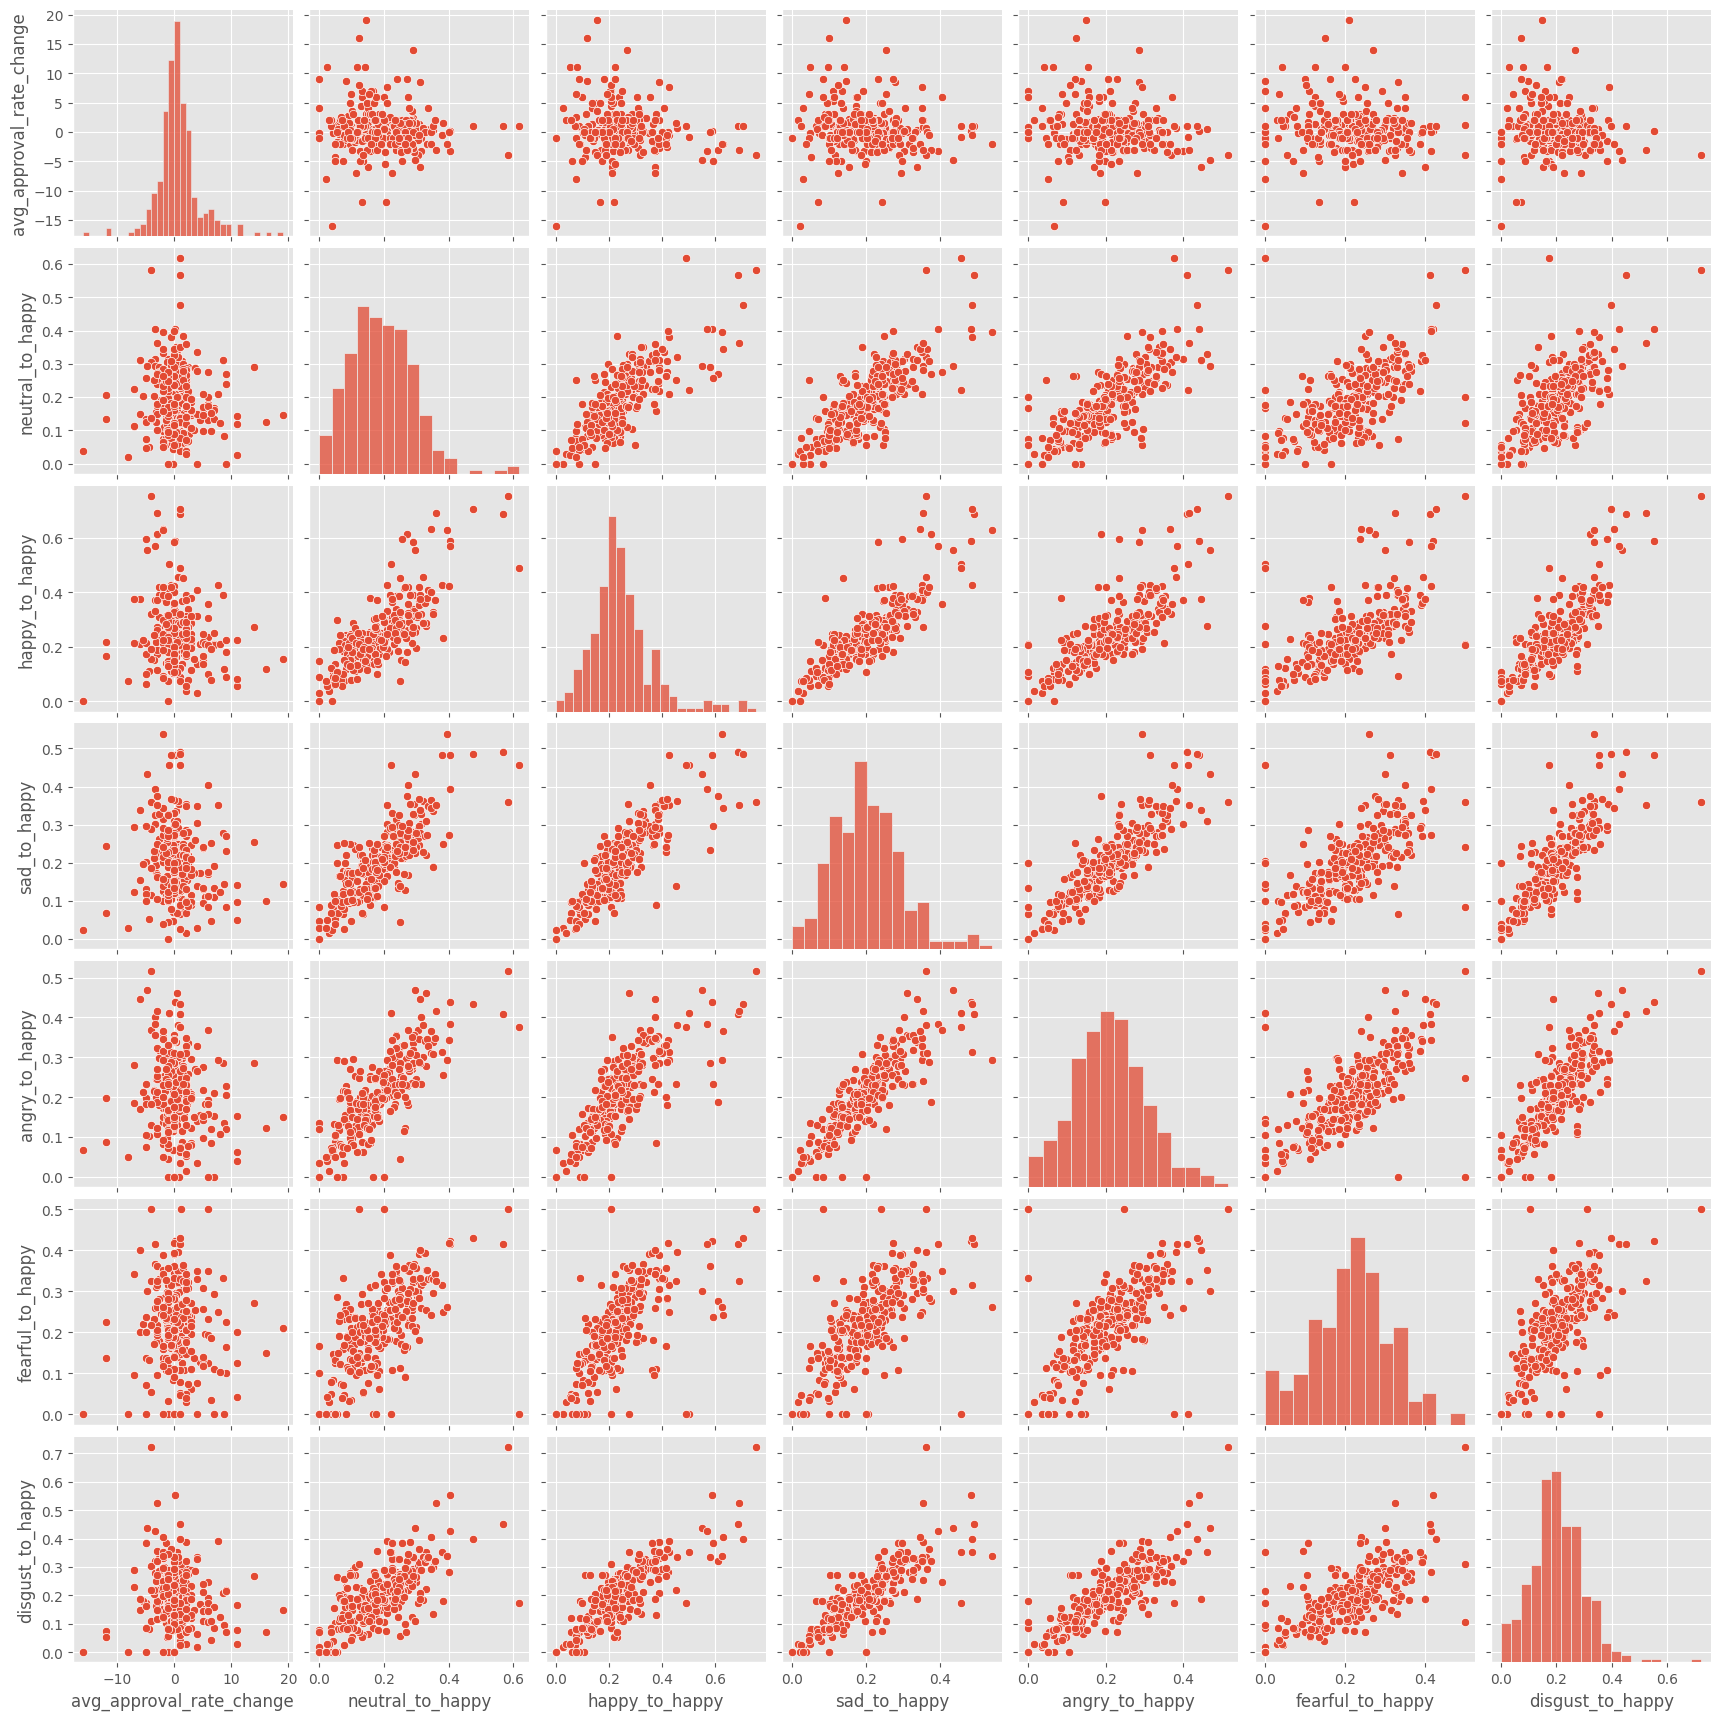

In [24]:
sns.pairplot(happy_data)

# OLS

In [27]:
ols = OLS(y, sm.add_constant(x)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     avg_approval_rate_change   R-squared:                       0.035
Model:                                  OLS   Adj. R-squared:                  0.014
Method:                       Least Squares   F-statistic:                     1.644
Date:                      Fri, 21 Jul 2023   Prob (F-statistic):              0.135
Time:                              13:37:35   Log-Likelihood:                -757.61
No. Observations:                       278   AIC:                             1529.
Df Residuals:                           271   BIC:                             1555.
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.3878      0.595      2.334      0.020       0.217       2.558
neutral_to_happy     4.7224      4.198      1.125      0.262      -3.542      12.987
happy_to_happy      -5.4536      3.991     -1.367      0.173     -13.310       2.403
sad_to_happy         4.7280      5.708      0.828      0.408      -6.510      15.966
angry_to_happy     -11.2176      5.346     -2.098      0.037     -21.743      -0.692
fearful_to_happy     3.5533      3.313      1.073      0.284      -2.969      10.075
disgust_to_happy     0.7041      4.842      0.145      0.884      -8.828      10.236
==============================================================================
Omnibus:                       51.815   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.834
Skew:                           0.531   Prob(JB):                     1.07e-71
Kurtosis:                       8.205   Cond. No.                         33.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
def MSE(y, x, coeff):
    b0,b1,b2,b3,b4,b5,b6 = coeff
    y_pred = x.iloc[:,0]*b1 + x.iloc[:,1]*b2 + x.iloc[:,2]*b3 + x.iloc[:,3]*b4 + x.iloc[:,4]*b5 + x.iloc[:,5]*b6 + b0
    n = len(y)
    mse = (1/n)*np.sum((y - y_pred)**2)
    rmse = np.sqrt((1/n)*np.sum((y - y_pred)**2))
    return mse, rmse, y_pred

0.00000000000000073482
13.63348842283183


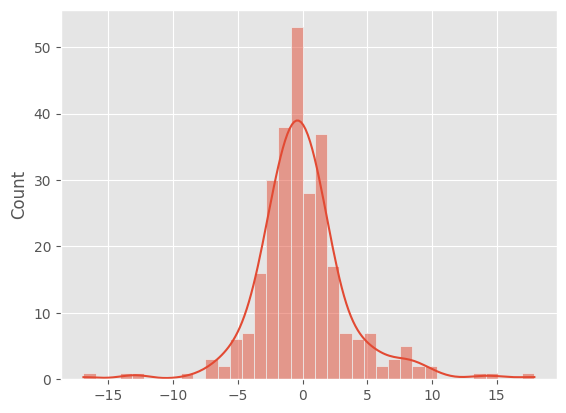

In [29]:
epsilon1 = y-MSE(y,x,ols.params)[2]
sns.histplot(epsilon1, kde = True)
print(f'{np.mean(epsilon1):.20f}')
print(np.var(epsilon1))

13.63348842283182982271
1339.1359813367196


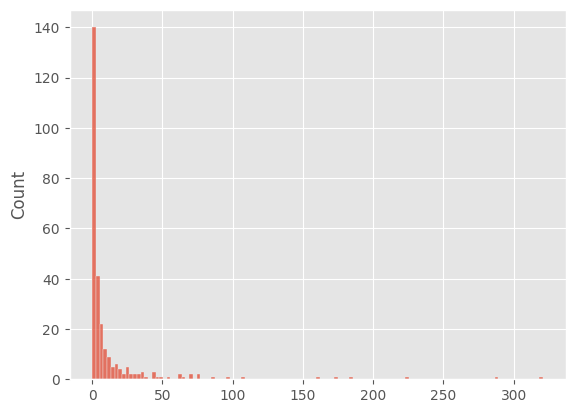

In [30]:
residual = epsilon1**2
sns.histplot(residual)
print(f'{np.mean(residual):.20f}')
print(np.var(residual))

In [32]:
wls = WLS(happy_data['avg_approval_rate_change'], sm.add_constant(happy_data.drop('avg_approval_rate_change', axis = 1)), weights = 1/residual).fit()
wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               WLS Regression Results                               
====================================================================================
Dep. Variable:     avg_approval_rate_change   R-squared:                       0.846
Model:                                  WLS   Adj. R-squared:                  0.843
Method:                       Least Squares   F-statistic:                     248.3
Date:                      Fri, 21 Jul 2023   Prob (F-statistic):          4.99e-107
Time:                              13:38:28   Log-Likelihood:                -473.71
No. Observations:                       278   AIC:                             961.4
Df Residuals:                           271   BIC:                             986.8
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.3277      0.044     30.123      0.000       1.241       1.414
neutral_to_happy     4.7599      0.394     12.088      0.000       3.985       5.535
happy_to_happy      -5.9521      0.326    -18.232      0.000      -6.595      -5.309
sad_to_happy         4.6389      0.457     10.159      0.000       3.740       5.538
angry_to_happy     -10.3271      0.593    -17.419      0.000     -11.494      -9.160
fearful_to_happy     3.3284      0.222     15.022      0.000       2.892       3.765
disgust_to_happy     0.7647      0.531      1.441      0.151      -0.280       1.809
==============================================================================
Omnibus:                     1484.504   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.256
Skew:                           0.252   Prob(JB):                     4.05e-10
Kurtosis:                       1.134   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
def estimator(data, outcome):
    for i in data.keys():
        subset = data[i]
        y = subset[outcome] 
        x = subset.drop(outcome, axis = 1)
        ols = OLS(y, sm.add_constant(x)).fit()
        epsilon = y-MSE(y,x,ols.params)[2]
        residual = epsilon1**2
        wls = WLS(y,sm.add_constant(x), weights = 1/residual).fit()
        print(wls.summary())
        
estimator(emotion_data, 'avg_approval_rate_change')

                               WLS Regression Results                               
Dep. Variable:     avg_approval_rate_change   R-squared:                       0.283
Model:                                  WLS   Adj. R-squared:                  0.267
Method:                       Least Squares   F-statistic:                     17.80
Date:                      Fri, 21 Jul 2023   Prob (F-statistic):           2.18e-17
Time:                              13:38:43   Log-Likelihood:                -687.66
No. Observations:                       278   AIC:                             1389.
Df Residuals:                           271   BIC:                             1415.
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

### Combination Regression

In [46]:
combine_list = list(itertools.combinations(prob_emote.keys(), 6))

In [53]:
prob_emote[list(combine_list[1])]

,disgust_to_disgust,disgust_to_happy,disgust_to_neutral,disgust_to_sad,disgust_to_angry,happy_to_disgust
0,0.580607,0.179907,0.066589,0.110981,0.049065,0.265378
1,0.236304,0.231023,0.147855,0.234323,0.108251,0.166023
2,0.290224,0.240326,0.084521,0.183299,0.158859,0.259887
3,0.116822,0.182243,0.364486,0.126168,0.130841,0.064234
4,0.293651,0.218254,0.103175,0.214286,0.091270,0.324176
...,...,...,...,...,...,...
273,0.190229,0.168399,0.166320,0.073805,0.270270,0.230855
274,0.119850,0.183521,0.273408,0.168539,0.209738,0.081690
275,0.167453,0.523585,0.122642,0.141509,0.023585,0.060646
276,0.122056,0.218415,0.319058,0.169165,0.128480,0.098018


In [110]:
def combination_regression(tuples):
    combine = np.zeros(shape=(len(tuples), len(prob_emote.keys())))
    coef_data = pd.DataFrame(combine, columns= prob_emote.keys())                          
    t_data = pd.DataFrame(combine, columns = prob_emote.keys())

    for j,i in enumerate(tuples):
        x = sm.add_constant(prob_emote[list(i)])
        ols = OLS(y, x).fit()
        epsilon1 = y-MSE(y,x,ols.params)[2]
        residual = epsilon1**2
        wls = WLS(y, x, weights = 1/residual).fit()

        coef_data.loc[j, list(i)] = wls.params
        t_data.loc[j, list(i)] = wls.tvalues
        print(j)
    
    return coef_data, t_data

In [ ]:
regress_data = combination_regression(combine_list)
regress_data[0].to_csv('coeff_data.csv', index = False)
regress_data[1].to_csv('tvalue_data.csv', index=False)

In [3]:
coeff_data = pd.read_csv('coeff_data.csv').replace(0, np.nan)
t_data = pd.read_csv('tvalue_data.csv').replace(0, np.nan)

In [30]:
avg_data = pd.concat([coeff_data.mean(axis = 0, skipna=True), t_data.mean(axis=0, skipna=True)], axis = 1).rename(columns={0: 'coeff', 1: 't_value'})
avg_data[(np.abs(avg_data['coeff']) > 1) & (np.abs(avg_data['t_value']) > 2)]

,coeff,t_value
disgust_to_happy,-2.390100,-11.291524
disgust_to_neutral,-1.032708,-4.603276
disgust_to_sad,4.645377,18.031845
disgust_to_fearful,-9.638625,-10.535086
happy_to_happy,-3.815171,-18.210532
happy_to_neutral,3.641925,10.663942
happy_to_angry,6.551711,15.583186
happy_to_fearful,13.523076,12.345104
neutral_to_disgust,3.685323,18.786923
neutral_to_sad,-1.022315,-4.498721
